# Analysis of the pit crew performance and its relationship to the Formula 1 championship standings

During this project, we try to identify the best perfoming teams in pit crew efficiency and analyze if the pit crew has a significant impact in the F1 world championship for the drivers and for the constructors.

To do so, we will put together the real standing and we will create a pit stops championship to be able to compare the results. Then, we will use different models to look if the pitcrew efficiency is significant.

In [99]:
# Import of the libraries that we will need for this project

import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, kendalltau

In [7]:
# Import of the data that we will need for this project

#Put here the path on your computer where the data are stored
path = "/Users/thomas/Documents/Master/Data/Project_Data/archive/"

lap_times = pd.read_csv(path + "lap_times.csv")
pit_stops = pd.read_csv(path + "pit_stops.csv")
circuits = pd.read_csv(path + "circuits.csv")
drivers = pd.read_csv(path + "drivers.csv")
races = pd.read_csv(path + "races.csv")
status = pd.read_csv(path + "status.csv")
constructors = pd.read_csv(path + "constructors.csv")
results = pd.read_csv(path + "results.csv")

First, we look at the main csv file that we will need to look at the pit efficiency, that is the pit stops csv file:

In [9]:
pit_stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10990 entries, 0 to 10989
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   raceId        10990 non-null  int64 
 1   driverId      10990 non-null  int64 
 2   stop          10990 non-null  int64 
 3   lap           10990 non-null  int64 
 4   time          10990 non-null  object
 5   duration      10990 non-null  object
 6   milliseconds  10990 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 601.1+ KB


In [11]:
pit_stops.head()

,raceId,driverId,stop,lap,time,duration,milliseconds
0,841,153,1,1,17:05:23,26.898,26898
1,841,30,1,1,17:05:52,25.021,25021
2,841,17,1,11,17:20:48,23.426,23426
3,841,4,1,12,17:22:34,23.251,23251
4,841,13,1,13,17:24:10,23.842,23842


As we can see, the column "duration" is of type object, which is not optimal to do calculations on it. So we'll create a function to convert these objects into float numbers without introducing NaN.

In [16]:
def convert_to_seconds(time_str):
    try:
        # Case for 'minutes:seconds.milliseconds'
        if ':' in time_str:
            minutes, seconds = time_str.split(':')
            seconds, milliseconds = seconds.split('.')
            total_seconds = int(minutes) * 60 + int(seconds) + int(milliseconds) / 1000
        # Case for 'seconds.milliseconds'
        else:
            seconds, milliseconds = time_str.split('.')
            total_seconds = int(seconds) + int(milliseconds) / 1000
        return total_seconds
    except:
        return None  # Return None if the format is invalid

Now we can create our pit stops dataframe with the data we need.

To do so, we make the hypothesis that if a driver doesn't finish the race, or if he finishes with a delay of more than 3 laps, he is considered as DNF and he is not elligible for the pit stop championship.

In order to work with this hypothesis, we first need to look at the lap times of each race we will analyze and create a set of drivers, for each race, that will not be taken into account. 

In [19]:
# First, we add that year column (present in the dataframe races) to the lap times dataframe
mylaptimes = pd.merge(lap_times, races[['raceId', 'year']], on='raceId', how='left')

# Then, we pick only the years that will be coherent with the pit stops dataframe, that is between the years 2011 and 2023. We don't consider the year
# 2024 as the season is not over at the moment we create this project.
mylaptimes = mylaptimes[(mylaptimes['year'] >= 2011) & (mylaptimes['year'] < 2024)]

# Now, we filter the dataframe status in order to keep only the status we defined earlier. Those are 'finished' and all the status that contain a '+',
# ('+1 lap', '+2 laps', and so on)
valid_status = status[status['status'].str.contains('finished|\\+', case=False, na=False)]

# We add these status to our lap times dataframe
mylaptimes = pd.merge(mylaptimes, results[['raceId', 'driverId', 'statusId']], on=['raceId', 'driverId'], how='left')

# Then, we keep only the good candidates for our pit stop championship
mylaptimes_filtered = mylaptimes[mylaptimes['statusId'].isin(valid_status['statusId'])]
mylaptimes_filtered2 = mylaptimes_filtered[mylaptimes_filtered['statusId']<13]
valid_data = mylaptimes_filtered2.groupby(['raceId', 'driverId'], as_index=False).agg({
    'year': 'first',
    'statusId': 'first'
 })

# Finally, we create the pit_stop basis on which we will be able to start working on with only the drivers we want to consider
filtered_pit_stops = pd.merge(pit_stops, valid_data[['raceId', 'driverId']], on=['raceId', 'driverId'], how='inner')

### Creation of the pit stop dataframe and visualization

In [21]:
# We include the necessary data to create the driver pit stops championship

mypitstops = pd.merge(filtered_pit_stops, races[['raceId', 'name', 'year']], on = 'raceId')
mypitstops = pd.merge(mypitstops, drivers[['driverId', 'driverRef']], on = 'driverId')
mypitstops['duration'] = mypitstops['duration'].apply(convert_to_seconds)
mypitstops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9203 entries, 0 to 9202
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   raceId        9203 non-null   int64  
 1   driverId      9203 non-null   int64  
 2   stop          9203 non-null   int64  
 3   lap           9203 non-null   int64  
 4   time          9203 non-null   object 
 5   duration      9203 non-null   float64
 6   milliseconds  9203 non-null   int64  
 7   name          9203 non-null   object 
 8   year          9203 non-null   int64  
 9   driverRef     9203 non-null   object 
dtypes: float64(1), int64(6), object(3)
memory usage: 719.1+ KB


As we can see, now the duration value is of type float, which is what we wanted to do our calculation.

Before doing any calculations, we look at the main statistical values of our pit stops dataframe.

In [23]:
mypitstops.describe(include='all')

,raceId,driverId,stop,lap,time,duration,milliseconds,name,year,driverRef
count,9203.000000,9203.000000,9203.000000,9203.000000,9203,9203.000000,9.203000e+03,9203,9203.000000,9203
unique,NaN,NaN,NaN,NaN,7037,NaN,NaN,40,NaN,72
top,NaN,NaN,NaN,NaN,15:07:43,NaN,NaN,Spanish Grand Prix,NaN,hamilton
freq,NaN,NaN,NaN,NaN,5,NaN,NaN,563,NaN,489
mean,971.588504,532.256329,1.782354,25.816038,NaN,82.346993,8.234699e+04,NaN,2016.737368,NaN
std,85.401927,388.640376,0.937926,14.897336,NaN,301.743304,3.017433e+05,NaN,3.942041,NaN
min,841.000000,1.000000,1.000000,1.000000,NaN,12.897000,1.289700e+04,NaN,2011.000000,NaN
25%,893.000000,18.000000,1.000000,14.000000,NaN,21.890000,2.189000e+04,NaN,2013.000000,NaN
50%,964.000000,817.000000,2.000000,25.000000,NaN,23.529000,2.352900e+04,NaN,2016.000000,NaN
75%,1047.000000,832.000000,2.000000,36.000000,NaN,26.059500,2.605950e+04,NaN,2020.000000,NaN


Then, we keep only on the columns we will need to use to create our pit stop championship and we visualize the main features, first just by looking at the first five ligns of the dataframe and then using a histogram and a boxplot.

In [25]:
mypitstops.drop(columns = ['raceId', 'driverId', 'lap', 'time', 'milliseconds'], inplace = True)

In [27]:
mypitstops.head()

,stop,duration,name,year,driverRef
0,1,26.898,Australian Grand Prix,2011,alguersuari
1,1,23.426,Australian Grand Prix,2011,webber
2,1,23.251,Australian Grand Prix,2011,alonso
3,1,23.842,Australian Grand Prix,2011,massa
4,1,22.603,Australian Grand Prix,2011,vettel


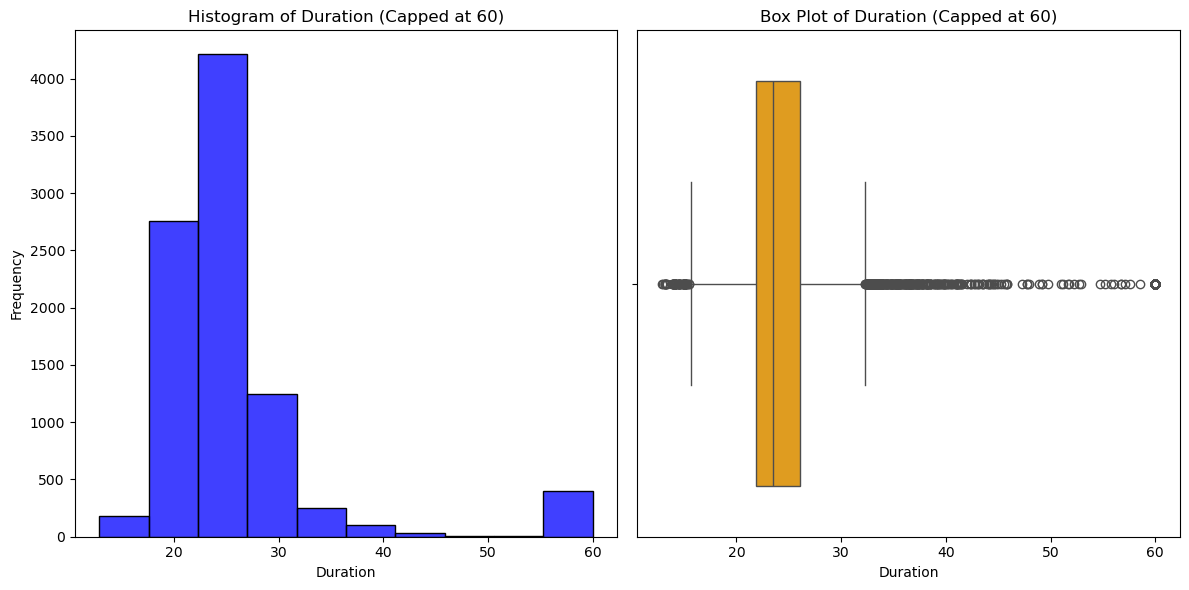

In [29]:
# Creation of the histogram and the boxplot

mypitstops['duration clipped'] = mypitstops['duration'].clip(upper=60)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Creation of the histogram
sns.histplot(mypitstops['duration clipped'], bins=10, ax=axes[0], color='blue')
axes[0].set_title('Histogram of Duration (Capped at 60)')
axes[0].set_xlabel('Duration')
axes[0].set_ylabel('Frequency')

# Creation of the boxplot
sns.boxplot(x=mypitstops['duration clipped'], ax=axes[1], color='orange')
axes[1].set_title('Box Plot of Duration (Capped at 60)')
axes[1].set_xlabel('Duration')

plt.tight_layout()
plt.show()


### Creation of the pit stop championship and the real championship for the drivers and constructors

We are now able to create our pit stop championship for the drivers.

To do so, we will use the same point distribution as for the drivers' championship. The point distribution is the following:

| Position | Points |
|:---:|:---:|
| 1st      | 25     |
| 2nd      | 18     |
| 3rd      | 15     |
| 4th      | 12     |
| 5th      | 10     |
| 6th      | 8      |
| 7th      | 6      |
| 8th      | 4      |
| 9th      | 2      |
| 10th     | 1      |

And all the remaining drivers get 0 points.

Then, we create a loop to create the pit stop championship for the drivers for each season. As the drivers stop more than once (on average) per race, we compute the average pit stop time during each race. Doing so, we will have the same amount of points in the pit stop championship than in the real drivers championship to have a proper comparison.


In [31]:
# Definition of the points distribution
points_distribution = [25, 18, 15, 12, 10, 8, 6, 4, 2, 1]

# We create a list of all the years we want for constructing our pit stop championships
year_unique = sorted(mypitstops['year'].unique())
year_unique = [year for year in year_unique if year < 2024]

yearly_points = {}

for year_wanted in year_unique:
    condition = mypitstops['year'] == year_wanted
    year_frame = mypitstops[condition]

    race_unique = year_frame['name'].unique()

    all_points = []

    for race_wanted in race_unique:
        filtered_year = year_frame[year_frame['name'] == race_wanted]

        max_stops = filtered_year.groupby('driverRef')['stop'].max().reset_index()
        total_duration = filtered_year.groupby('driverRef')['duration'].sum().reset_index()

        merged_df = pd.merge(max_stops, total_duration, on='driverRef')
        merged_df['mean'] = merged_df['duration'] / merged_df['stop']

        merged_df = merged_df.sort_values(by='mean', ascending=True)

        merged_df['pit_points'] = 0
        num_drivers = min(len(merged_df), len(points_distribution))
        merged_df.iloc[:num_drivers, merged_df.columns.get_loc('pit_points')] = points_distribution[:num_drivers]

        all_points.append(merged_df[['driverRef', 'pit_points']])

    combined_points = pd.concat(all_points, ignore_index=True)

    total_points = combined_points.groupby('driverRef', as_index=False)['pit_points'].sum()

    total_points = total_points.sort_values(by='pit_points', ascending=False)

    total_points['pit_rank'] = range(1, len(total_points) + 1)

    yearly_points[year_wanted] = total_points

Now that we have our pit stops championships, we create the real standings of each year in order to compare the results of each drivers. To do so, we will use the 'results' csv file which gives us the official result of each race of each season. We need to troncate it, as we want to keep only the seasons between 2011 and 2023.

In [33]:
mystanding = pd.merge(results, races[['raceId', 'year']], on = 'raceId')
mystanding = pd.merge(mystanding, drivers[['driverId', 'driverRef']], on = 'driverId')
mystanding = pd.merge(mystanding, constructors[['constructorId', 'constructorRef']], on = 'constructorId')

In [35]:
mystanding.drop(columns = ['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid', 'position', 'positionText', 'positionOrder', \
                           'laps', 'time', 'milliseconds', 'fastestLap', 'fastestLapTime', 'fastestLapSpeed', 'statusId'], inplace = True)

mystanding.drop(mystanding[(mystanding['year'] < 2011) | (mystanding['year'] >= 2024)].index, inplace=True)

In [37]:
# Creation of the real drivers' championship

championship = mystanding.groupby(['driverRef', 'year'])['points'].sum().reset_index()

season_standings = {}

for year in range(2011, 2024):
    current_yearly_points = yearly_points[year]
 
    current_yearly_points['driverRef'] = current_yearly_points['driverRef'].astype(str)

    standing = championship[championship['year'] == year].sort_values(by='points', ascending=False)
    standing['driverRef'] = standing['driverRef'].astype(str)

    standing['rank_std'] = range(1, len(standing) + 1)

    merged_standing = pd.merge(standing, current_yearly_points, on='driverRef', how='inner')

    final_merged = pd.merge(
        merged_standing,
        mystanding[['driverRef', 'year', 'constructorRef']],
        on=['year', 'driverRef']
    ).groupby('driverRef').agg({
        'points': 'first',
        'rank_std': 'first',
        'pit_points': 'first',
        'pit_rank': 'first',
        'constructorRef': 'first'
    })
    
    # Organization of the dataframe in order to have the best visulation possible
    final_merged = final_merged[['points', 'pit_points', 'rank_std', 'pit_rank', 'constructorRef']]

    final_merged = final_merged.sort_values(by='points', ascending=False)

    season_standings[year] = final_merged

for year, standings in season_standings.items():
    display_columns = ['points', 'pit_points', 'rank_std', 'pit_rank']
    print(f"Standing for the year {year} :")
    print(standings[display_columns])

Standing for the year 2011 :
                    points  pit_points  rank_std  pit_rank
driverRef                                                 
vettel               392.0         233         1         1
button               270.0         179         2         4
webber               258.0         176         3         5
alonso               257.0         138         4         6
hamilton             227.0         189         5         3
massa                118.0          82         6         9
rosberg               89.0         222         7         2
michael_schumacher    76.0         137         8         7
sutil                 42.0          52         9        13
petrov                37.0          53        10        12
heidfeld              34.0          36        11        16
kobayashi             30.0          33        12        17
resta                 27.0          84        13         8
alguersuari           26.0          36        14        15
buemi                 15.0 

Finally, we create the constructors' championships with the same display as for the drivers' championships.

In [47]:
constructors_std = {}

for season, df in season_standings.items():
    grouped = df.groupby('constructorRef').agg({
        'points': 'sum',
        'pit_points': 'sum'
    }).reset_index()

    grouped.sort_values(by='points', ascending=False, inplace=True)

    grouped['rank_std'] = range(1, len(grouped) + 1)

    grouped['pit_rank'] = grouped['pit_points'].rank(method='min', ascending=False).astype(int)

    grouped.set_index('constructorRef', inplace=True)

    constructors_std[season] = grouped

constructors_std

{2011:                 points  pit_points  rank_std  pit_rank
 constructorRef                                        
 red_bull         650.0         409         1         1
 mclaren          497.0         368         2         2
 ferrari          375.0         220         3         4
 mercedes         165.0         359         4         3
 renault           73.0         148         5         5
 force_india       69.0         136         6         6
 sauber            44.0          65         7         8
 toro_rosso        41.0          62         8         9
 williams           5.0         110         9         7
 hrt                0.0          18        10        11
 lotus_racing       0.0          23        11        10
 virgin             0.0           1        12        12,
 2012:                 points  pit_points  rank_std  pit_rank
 constructorRef                                        
 red_bull         460.0         403         1         2
 ferrari          400.0         417

### Visualisation of the results

Here, we will look at the evolution of the pit stops championship for the constructors.

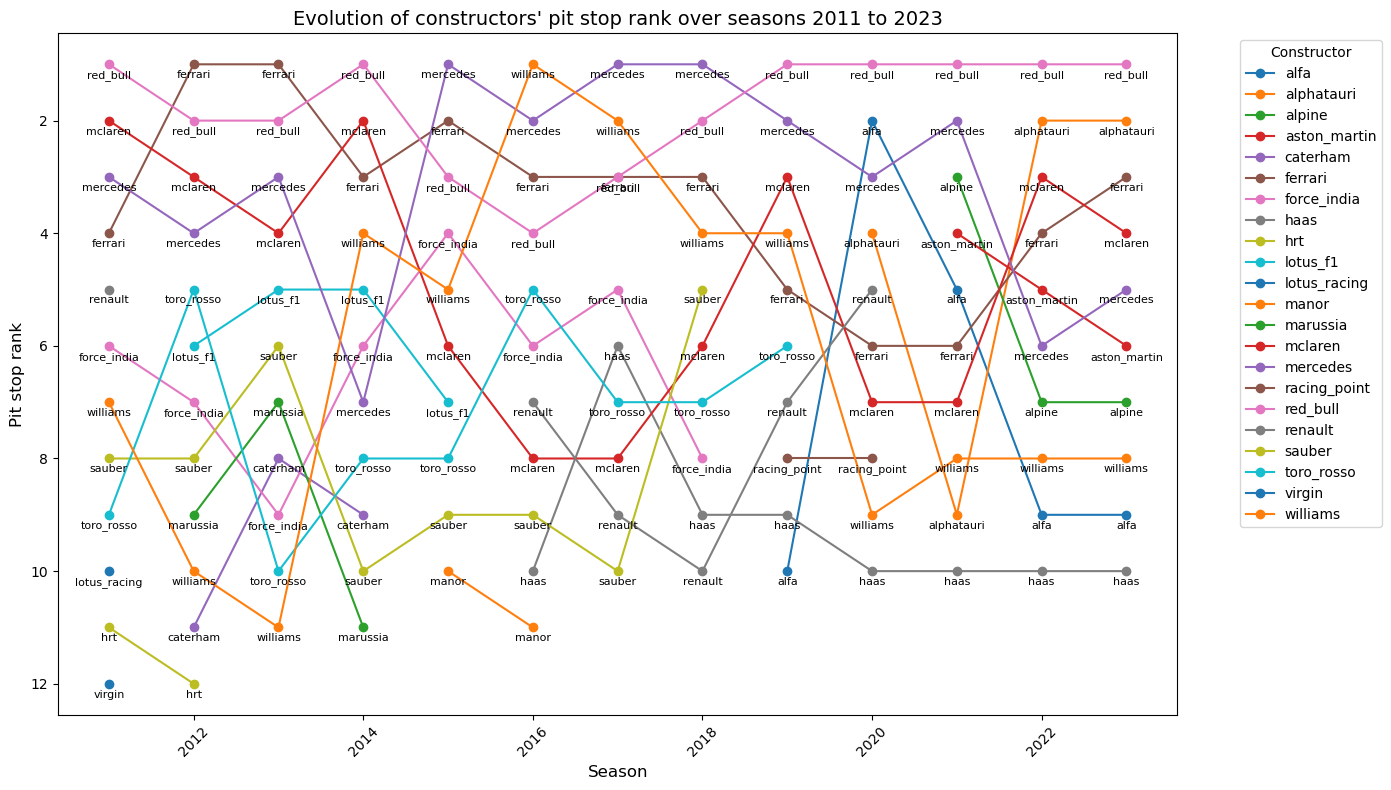

In [51]:
pit_rank_evolution = pd.DataFrame()

for season, df in constructors_std.items():
    season_ranks = df['pit_rank'].reset_index()
    season_ranks['season'] = season
    pit_rank_evolution = pd.concat([pit_rank_evolution, season_ranks], ignore_index=True)

pit_rank_evolution_pivot = pit_rank_evolution.pivot(index='constructorRef', columns='season', values='pit_rank')

plt.figure(figsize=(14, 8))
for constructor in pit_rank_evolution_pivot.index:
    data = pit_rank_evolution_pivot.loc[constructor]
    plt.plot(data.index, data.values, marker='o', label=constructor)

    for season, rank in zip(data.index, data.values):
        plt.annotate(constructor, (season, rank), textcoords="offset points", xytext=(0, -10), ha='center', fontsize=8)

plt.gca().invert_yaxis()  # Inversion of the Y axis because 1st is the best rank
plt.title("Evolution of constructors' pit stop rank over seasons 2011 to 2023", fontsize=14)
plt.xlabel("Season", fontsize=12)
plt.ylabel("Pit stop rank", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Constructor", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()


In [53]:
season_standings[2014]

,points,pit_points,rank_std,pit_rank,constructorRef
driverRef,,,,,
hamilton,384.0,65,1,13,mercedes
rosberg,317.0,86,2,10,mercedes
ricciardo,238.0,219,3,1,red_bull
bottas,186.0,72,4,11,williams
vettel,167.0,185,5,4,red_bull
alonso,161.0,208,6,2,ferrari
massa,134.0,113,7,7,williams
button,126.0,161,8,5,mclaren
hulkenberg,96.0,99,9,9,force_india


In [55]:
season_standings[2015]

,points,pit_points,rank_std,pit_rank,constructorRef
driverRef,,,,,
hamilton,381.0,271,1,1,mercedes
rosberg,322.0,209,2,3,mercedes
vettel,278.0,239,3,2,ferrari
raikkonen,150.0,155,4,4,ferrari
bottas,136.0,96,5,8,williams
massa,121.0,90,6,9,williams
kvyat,95.0,123,7,5,red_bull
ricciardo,92.0,102,8,7,red_bull
perez,78.0,108,9,6,force_india


In [83]:
constructors_std[2015]

,points,pit_points,rank_std,pit_rank
constructorRef,,,,
mercedes,703.0,480,1,1
ferrari,428.0,394,2,2
williams,257.0,186,3,5
red_bull,187.0,225,4,3
force_india,136.0,194,5,4
lotus_f1,78.0,116,6,7
toro_rosso,67.0,89,7,8
sauber,36.0,83,8,9
mclaren,27.0,146,9,6


In [89]:
constructors_std[2014]

,points,pit_points,rank_std,pit_rank
constructorRef,,,,
mercedes,701.0,151,1,7
red_bull,405.0,404,2,1
williams,320.0,185,3,4
ferrari,216.0,326,4,3
mclaren,181.0,361,5,2
force_india,155.0,157,6,6
toro_rosso,30.0,51,7,8
lotus_f1,10.0,173,8,5
marussia,2.0,31,9,11


### Creation of the models

In this part, we analyze the correlation between the pit_points and the real points, as well as the correlation between the pit_rank and the real rank. To do so, we will calculate the correlation between them (the Pearson correlation, the Spearman correlation and the Kendall Tau correlation). Moreover, we will do an OLS regression between and the points and another one between the ranks.

We start by doing this for the drivers:

In [58]:
# First, we need to combine all the seasons into one single dataframe
all_seasons = pd.concat(
    [df.assign(year=year) for year, df in season_standings.items()],
    ignore_index=True)

In [78]:
# Then, we calculate the correlation between the championship rank and the pit stop rank
correlation = all_seasons['rank_std'].corr(all_seasons['pit_rank'])

print(f"Pearson correlation between Championship Ranks and Pit Stop Ranks: {correlation:.4f}")

# Not ideal for ranks

Pearson correlation between Championship Ranks and Pit Stop Ranks: 0.7611


In [84]:
# The correlation between the championship points and the real points
correlation_points = all_seasons['points'].corr(all_seasons['pit_points'])

print(f"Pearson correlation between Championship Points and Pit Stop Points: {correlation_points:.4f}")

Pearson correlation between Championship Points and Pit Stop Points: 0.7443


In [82]:
# The spearman correlation between the pit rank and the championship rank
spearman_corr, spearman_p = spearmanr(all_seasons['pit_rank'], all_seasons['rank_std'])

# the kendall tau correlation between the pit rank and the championship rank
kendall_corr, kendall_p = kendalltau(all_seasons['pit_rank'], all_seasons['rank_std'])

print(f"Spearman Correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")
print(f"Kendall Tau Correlation: {kendall_corr:.4f}, p-value: {kendall_p:.4f}")

Spearman Correlation: 0.7584, p-value: 0.0000
Kendall Tau Correlation: 0.5842, p-value: 0.0000


                            OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     362.7
Date:                Tue, 03 Dec 2024   Prob (F-statistic):           3.94e-53
Time:                        18:59:25   Log-Likelihood:                -1682.5
No. Observations:                 294   AIC:                             3369.
Df Residuals:                     292   BIC:                             3376.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -13.1937      6.956     -1.897      0.0

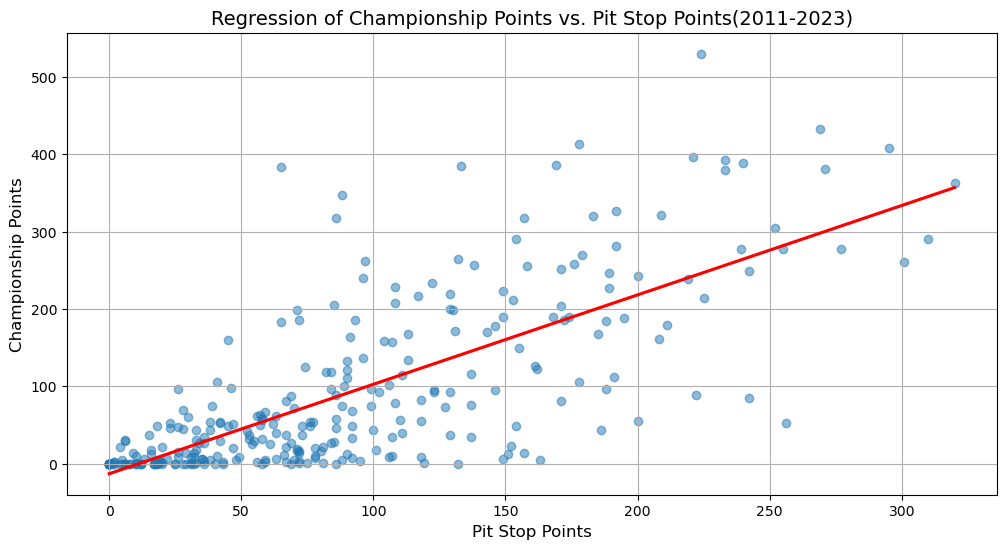

In [92]:
# We perform an OLS regression between the pit points (on the x axis) and the championship points (on the y axis)
x = all_seasons['pit_points']
y = all_seasons['points']

x = sm.add_constant(x)

model2 = sm.OLS(y, x)
results2 = model2.fit()

print(results2.summary())

plt.figure(figsize=(12, 6))
sns.regplot(
    data=all_seasons,
    x='pit_points',
    y='points',
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'},
    ci=None
)
plt.title("Regression of Championship Points vs. Pit Stop Points(2011-2023)", fontsize=14)
plt.xlabel("Pit Stop Points", fontsize=12)
plt.ylabel("Championship Points", fontsize=12)
plt.grid(True)
plt.show()

And we do exactly the same steps for the constructors' correlations and OLS regression.

In [68]:
# First, we need to combine all the seasons into one single dataframe
all_seasons_constructors = pd.concat(
    [df.assign(year=year) for year, df in constructors_std.items()],
    ignore_index=True
)

In [88]:
# Then, we calculate the correlation between the championship rank and the pit stop rank
correlation = all_seasons_constructors['rank_std'].corr(all_seasons_constructors['pit_rank'])

print(f"Pearson correlation between Constructor Championship Ranks and Pit Stop Ranks: {correlation:.4f}")

#Again, not the ideal metrics for ranks

Pearson correlation between Constructor Championship Ranks and Pit Stop Ranks: 0.7409


In [86]:
# The correlation between the championship points and the pit points
correlation_points = all_seasons_constructors['points'].corr(all_seasons_constructors['pit_points'])

print(f"Pearson correlation between Constructor Championship Points and Pit Stop Points: {correlation_points:.4f}")

Pearson correlation between Constructor Championship Points and Pit Stop Points: 0.7554


In [81]:
# We compute the spearman correlation between the pit_rank and the real rank
spearman_corr, spearman_p = spearmanr(all_seasons_constructors['pit_rank'], all_seasons_constructors['rank_std'])

# We compute the kendall tau correlation between the pit_rank and the real rank
kendall_corr, kendall_p = kendalltau(all_seasons_constructors['pit_rank'], all_seasons_constructors['rank_std'])

print(f"Spearman Correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")
print(f"Kendall Tau Correlation: {kendall_corr:.4f}, p-value: {kendall_p:.4f}")

Spearman Correlation: 0.7380, p-value: 0.0000
Kendall Tau Correlation: 0.5980, p-value: 0.0000


                            OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     179.4
Date:                Tue, 03 Dec 2024   Prob (F-statistic):           1.48e-26
Time:                        18:59:18   Log-Likelihood:                -870.99
No. Observations:                 137   AIC:                             1746.
Df Residuals:                     135   BIC:                             1752.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -39.1702     21.163     -1.851      0.0

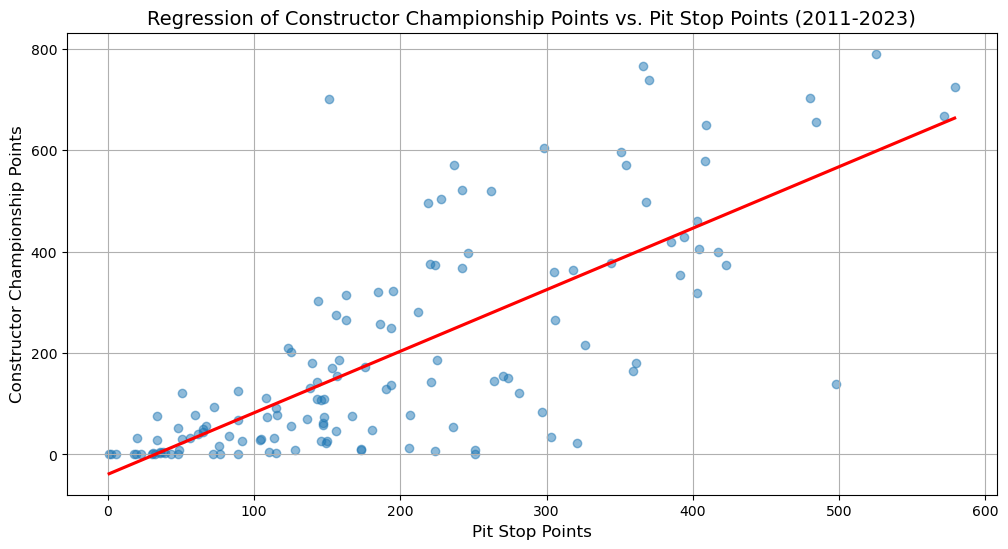

In [90]:
# Finally, we do the OLS regression between the pit_points (on the x axis) and the real points (on the y axis)
x = all_seasons_constructors['pit_points']
y = all_seasons_constructors['points']

x = sm.add_constant(x)

model4 = sm.OLS(y, x)
results4 = model4.fit()

print(results4.summary())

plt.figure(figsize=(12, 6))
sns.regplot(
    data=all_seasons_constructors,
    x='pit_points',
    y='points',
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'},
    ci=None
)
plt.title("Regression of Constructor Championship Points vs. Pit Stop Points (2011-2023)", fontsize=14)
plt.xlabel("Pit Stop Points", fontsize=12)
plt.ylabel("Constructor Championship Points", fontsize=12)
plt.grid(True)
plt.show()

### Alternative models

                            OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     182.0
Date:                Tue, 03 Dec 2024   Prob (F-statistic):           5.49e-52
Time:                        19:02:32   Log-Likelihood:                -1681.9
No. Observations:                 294   AIC:                             3370.
Df Residuals:                     291   BIC:                             3381.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.7227      9.325     -0.721      0.4

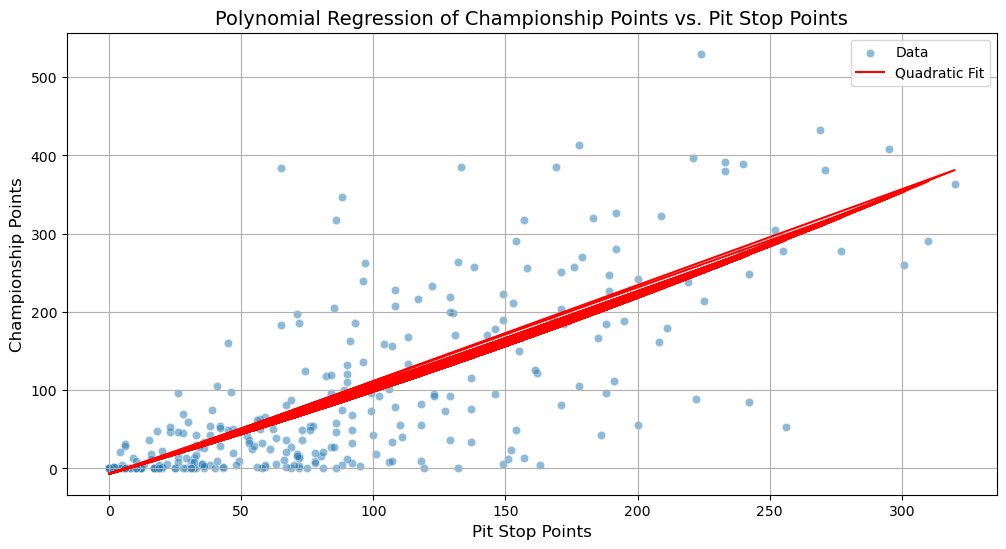

In [101]:
# Adding a polynomial term (quadratic)
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
x_poly = poly.fit_transform(all_seasons[['pit_points']])

model_poly = sm.OLS(y, sm.add_constant(x_poly))
results_poly = model_poly.fit()

print(results_poly.summary())

plt.figure(figsize=(12, 6))
sns.scatterplot(data=all_seasons, x='pit_points', y='points', alpha=0.5, label="Data")
plt.plot(
    all_seasons['pit_points'],
    results_poly.predict(sm.add_constant(x_poly)),
    color='red',
    label="Quadratic Fit"
)
plt.title("Polynomial Regression of Championship Points vs. Pit Stop Points", fontsize=14)
plt.xlabel("Pit Stop Points", fontsize=12)
plt.ylabel("Championship Points", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

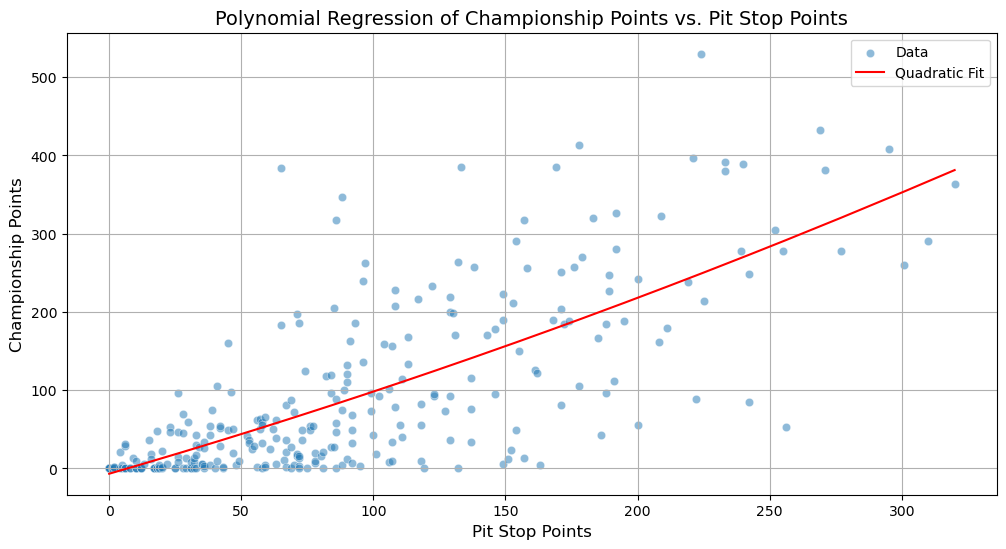

In [113]:
# To have a cleaner graph for the report:

sorted_data = all_seasons.sort_values(by='pit_points')
x_poly_sorted = poly.transform(sorted_data[['pit_points']]) 


plt.figure(figsize=(12, 6))
sns.scatterplot(data=all_seasons, x='pit_points', y='points', alpha=0.5, label="Data")
plt.plot(
    sorted_data['pit_points'],
    results_poly.predict(sm.add_constant(x_poly_sorted)),
    color='red',
    label="Quadratic Fit"
)
plt.title("Polynomial Regression of Championship Points vs. Pit Stop Points", fontsize=14)
plt.xlabel("Pit Stop Points", fontsize=12)
plt.ylabel("Championship Points", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

                            OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     91.28
Date:                Tue, 03 Dec 2024   Prob (F-statistic):           4.44e-50
Time:                        19:03:52   Log-Likelihood:                -1681.1
No. Observations:                 294   AIC:                             3372.
Df Residuals:                     289   BIC:                             3391.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

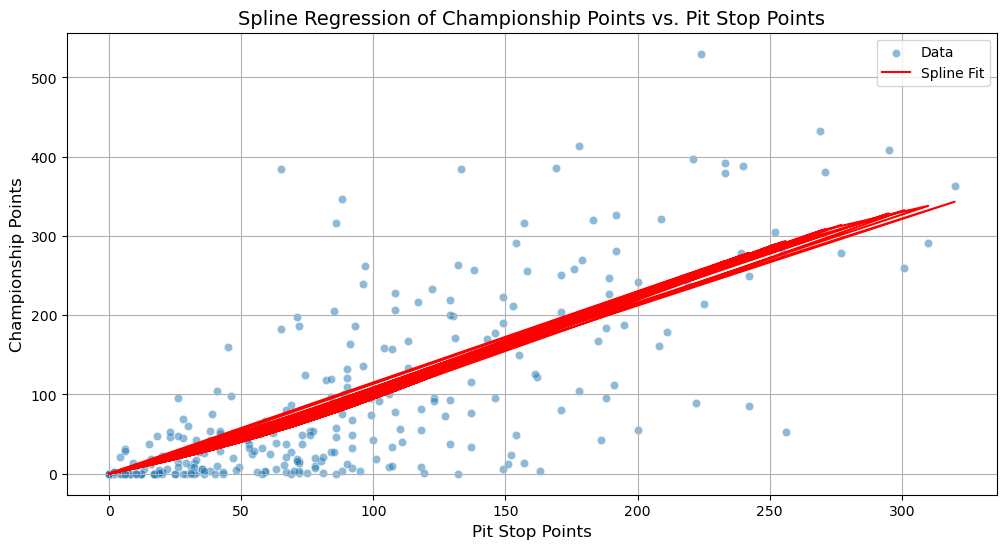

In [105]:
from patsy import dmatrix

# Create spline basis for pit_points
spline_basis = dmatrix("bs(all_seasons['pit_points'], df=4)", return_type='dataframe')

model_spline = sm.OLS(y, spline_basis)
results_spline = model_spline.fit()

print(results_spline.summary())

plt.figure(figsize=(12, 6))
sns.scatterplot(data=all_seasons, x='pit_points', y='points', alpha=0.5, label="Data")
plt.plot(
    all_seasons['pit_points'],
    results_spline.predict(spline_basis),
    color='red',
    label="Spline Fit"
)
plt.title("Spline Regression of Championship Points vs. Pit Stop Points", fontsize=14)
plt.xlabel("Pit Stop Points", fontsize=12)
plt.ylabel("Championship Points", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

                            OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     91.28
Date:                Tue, 03 Dec 2024   Prob (F-statistic):           4.44e-50
Time:                        19:05:48   Log-Likelihood:                -1681.1
No. Observations:                 294   AIC:                             3372.
Df Residuals:                     289   BIC:                             3391.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

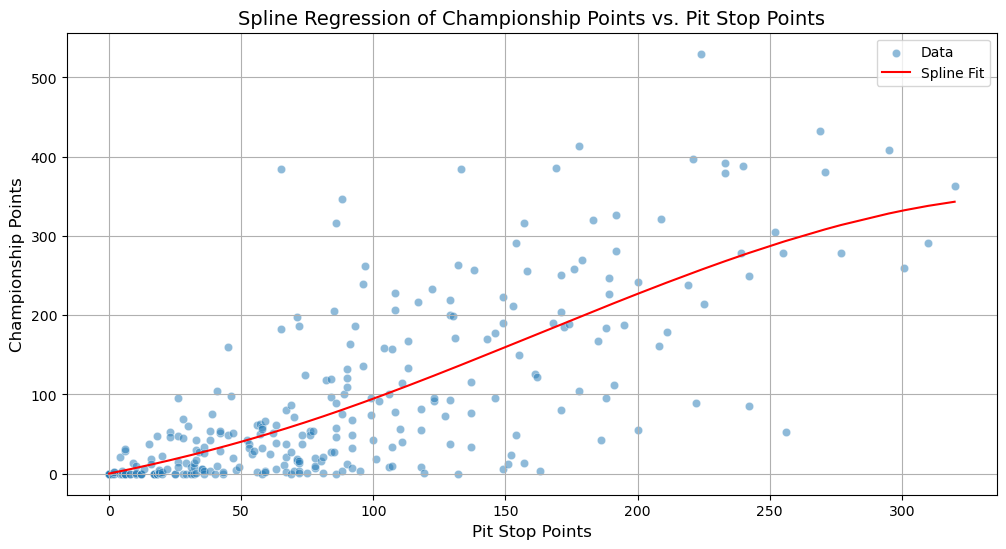

In [111]:
# For a cleaner graph for the report

all_seasons = all_seasons.sort_values(by='pit_points') 
y = all_seasons['points'] 

spline_basis = dmatrix("bs(all_seasons['pit_points'], df=4)", return_type='dataframe')

spline_basis = spline_basis.set_index(all_seasons.index)

model_spline = sm.OLS(y, spline_basis)
results_spline = model_spline.fit()

print(results_spline.summary())

plt.figure(figsize=(12, 6))
sns.scatterplot(data=all_seasons, x='pit_points', y='points', alpha=0.5, label="Data")
plt.plot(
    all_seasons['pit_points'],
    results_spline.predict(spline_basis),
    color='red',
    label="Spline Fit"
)
plt.title("Spline Regression of Championship Points vs. Pit Stop Points", fontsize=14)
plt.xlabel("Pit Stop Points", fontsize=12)
plt.ylabel("Championship Points", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()